In [17]:
import os, sys
from scipy.misc import imread, imresize
import skimage.io
import skimage.transform

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

print ("packages are loaded")

packages are loaded


In [18]:
img_path = ["img/city", "img/country"]

img_size = [64, 64]
cvt2gray = True

In [19]:
def rgb2gray(rgb_img) :
    if (len(rgb_img.shape) == 3) :
        return np.dot(rgb_img, [0.299, 0.587, 0.114])
    else :
        return rgb_img


In [20]:
valid_exts = [".jpg", ".gif", ".png", ".tga", ".jpeg", ".bmp"]

class_n = len(img_path)
image_count = 0
dataset_img = []
dataset_label = []

for idx, path in enumerate(img_path) :
    files = os.listdir(path)
    for one_f in files :
        if os.path.splitext(one_f)[1].lower() not in valid_exts :
            continue
        one_img = imread(path + '/' + one_f)
        if cvt2gray :
            one_img = rgb2gray(one_img)
        one_img_small = imresize(one_img, [img_size[0], img_size[1]])
        one_img_vector = np.reshape(one_img_small, (-1,))
        dataset_img.append(one_img_vector)
        dataset_label.append(np.eye(class_n,class_n)[idx])
        image_count += 1
dataset_img = np.array(dataset_img)
dataset_label = np.array(dataset_label)

print ("dataset img shape : " + str(dataset_img.shape))
print ("dataset label shape : " + str(dataset_label.shape))
print ("Loaded class count : " + str(class_n))
print ("Loaded image count : " + str(image_count))

dataset img shape : (22, 4096)
dataset label shape : (22, 2)
Loaded class count : 2
Loaded image count : 22


In [21]:
# Devide data into train/valid/test set
def divide_dataset(dataset_feature, dataset_label, divide_key, divide_ratio):
    res = {}
    rsum = np.sum(divide_ratio)
    n_dataset = len(dataset_feature)
    for idx in range(len(divide_ratio) - 1):
        now_nds = dataset_feature.shape[0]
        n_section = n_dataset * divide_ratio[idx] / rsum
        rand_idx = np.arange(now_nds)
        np.random.shuffle(rand_idx)
        rand_idx =  rand_idx[:n_section]
        res[divide_key[idx]] = {"images":[], "labels":[]}
        res[divide_key[idx]]["images"] = dataset_feature[rand_idx,:]
        res[divide_key[idx]]["labels"] = dataset_label[rand_idx,:]
        dataset_feature = np.delete(dataset_feature,rand_idx,0)
        dataset_label = np.delete(dataset_label,rand_idx,0)
    res[divide_key[-1]] = {"images":[], "labels":[]}
    res[divide_key[-1]]["images"] = dataset_feature
    res[divide_key[-1]]["labels"] = dataset_label
    return res

res = divide_dataset(dataset_img, dataset_label, ["train", "test"], [8,1])
print ("train img shape : " + str(res['train']['images'].shape))
print ("train label shape : " + str(res['train']['labels'].shape))
print ("test img shape : " + str(res['test']['images'].shape))
print ("test label shape : " + str(res['test']['labels'].shape))


train img shape : (19, 4096)
train label shape : (19, 2)
test img shape : (3, 4096)
test label shape : (3, 2)


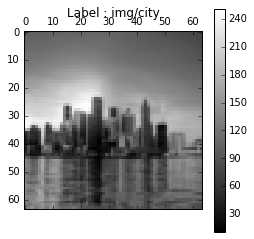

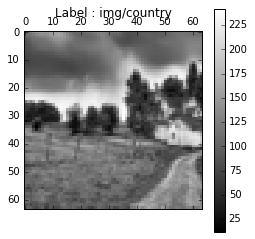

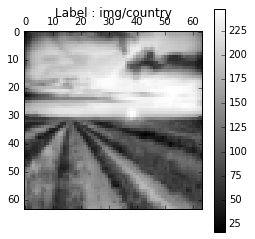

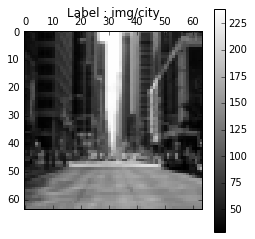

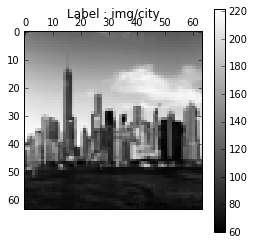

In [22]:
# Plot image
rand_idx = np.arange(res['train']['images'].shape[0])
np.random.shuffle(rand_idx)
rand_idx =  rand_idx[:5]

for idx in rand_idx:
    label = np.argmax(res['train']['labels'][idx])
    if cvt2gray:
        img = np.reshape(res['train']['images'][idx], (img_size[0],img_size[1]))
        plt.matshow(img,cmap=plt.get_cmap('gray'))
    else:
        img = p.reshape(res['train']['images'][idx], (img_size[0],img_size[1],3))
        plt.imshow(img)
    plt.colorbar()
    plt.title("Label : " + str(img_path[label]))
    plt.show()

In [23]:
# Save npz data
npz_path = "img/MYIMG/my_img.npz"

np.savez(npz_path, \
         train_img = res['train']['images'], train_label = res['train']['labels'],\
         test_img = res['test']['images'], test_label = res['test']['labels']\
        )

print ("Saved in " + npz_path)

Saved in img/MYIMG/my_img.npz


In [24]:
# Load npz data
npz_path = "img/MYIMG/my_img.npz"

load_data = np.load(npz_path)
print ("Load data : " + str(load_data.files))

train_img = load_data['train_img']
train_label = load_data['train_label']
test_img = load_data['test_img']
test_label = load_data['test_label']

print ("train_img shape : "  + str(train_img.shape))
print ("test_img shape : "  + str(test_img.shape))

Load data : ['test_img', 'test_label', 'train_img', 'train_label']
train_img shape : (19, 4096)
test_img shape : (3, 4096)


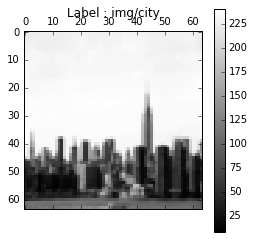

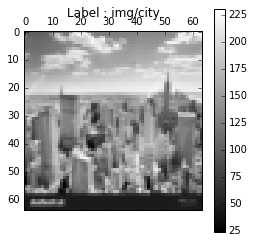

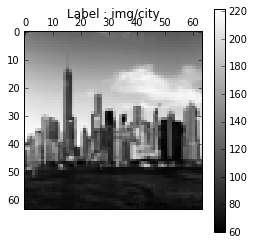

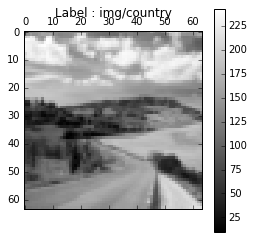

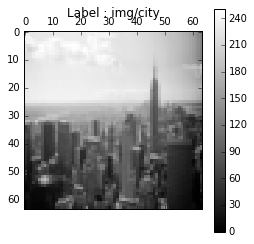

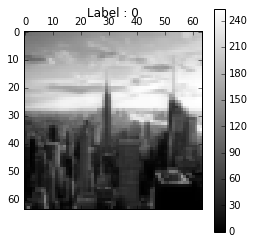

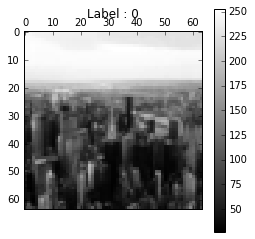

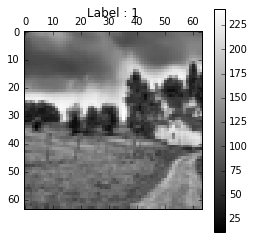

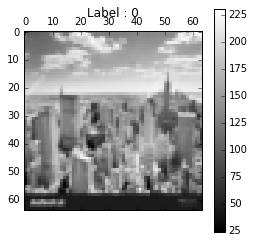

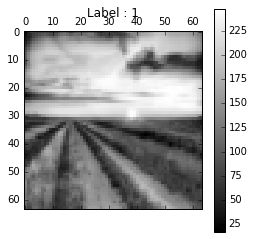

In [29]:
# Training Graph
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(train_img.shape[0]/batch_size)
    for i in range(num_batch):
        randidx = np.random.randint(train_img.shape[0], size=batch_size)
        batch_xs = train_img[randidx, :]
        batch_ys = train_label[randidx, :]                
            
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : drop_out_ratio})
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : 1.})/num_batch
            
    if epoch % display_step == 0:
        train_img_acc = sess.run(accr , ({x: batch_xs, y: batch_ys, drop_out_prob : 1.}))
        print ("epoch: %03d/%03d  ,  cost: %.6f  ,  train_img_acc: %.3f" \
               % (epoch, training_epochs, avg_cost, train_img_acc))

test_batch_size = 10
avg_acc = 0.
num_batch_test = int(test_img.shape[0]/test_batch_size)
for i in range(num_batch_test):
    batch_xs_test = test_img[i * test_batch_size : (i+1) * test_batch_size ]
    batch_ys_test = test_label[i * test_batch_size : (i+1) * test_batch_size ]            
    avg_acc += sess.run(accr, feed_dict={x : batch_xs_test, y : batch_ys_test, drop_out_prob : 1.})
    
print ("Training complete, Accuracy : %.6f" \
       % (avg_acc / num_batch_test,))

NameError: name 'tf' is not defined

NameError: name 'tf' is not defined